In [1]:
import sys
sys.path.append("./git/")

# Intro

## What is a decision tree?

A decision tree is a predictive modelling tool. They are used to predict the nature of things.

Decision trees are so called because they make use of a branching tree structure to represent a number of `decision paths` and an `outcome` for each path.

Decision trees are a mathematically fancier version of the game Twenty Questions:

- I am thinking of a sport.
- Is it a contact sport?
- Yes.
- Does it have teams?
- No.
- Does it require equipment to play?
- No.
- Does it require weigh-ins?
- Yes.
- Are you limited to using your hands?
- No.
- Is it MMA?
- Yes!

In this example the `decision path` is:

contact sport -> no teams -> no equipment -> weigh ins -> uses more than hands -> MMA

## Pros

- Easy to interpret. 
- Totally transparent.
- Works with a mix numerical and categorical data (real and natural numbers).
- Can apply to data which are missing attributes.

## Cons

- Optimising them is very difficult.
- Super easy to overfit to your training set.

So what questions do you ask? And in what order? How can you work this out?

At each step in the tree you eliminate some options. Some possibilities get negated.

Say you've a zoology dataset and you ask "does this animal have more than 5 legs?". This rules out spiders and ants, but leaves in dogs and ducks.

Each question and each decision in the tree filters down the data, partitioning the remaining options.

The best questions to ask, then, are ones which give you the most information about the problem at hand.

**As common sense dictates: any question you ask where the answer doesn't leave you better off is a bad question.**

## Mathematical entropy

This concept is translated mathetmatically to the concept of `entropy`. In engineering or physical sciences entropy is associated with disorder; in this context it is closer to uncertainty in the data.

In mathematical terms, say you have a dataset `S`, each member of which is labeled as belong to one of a finite number of classes $$C_1, C_2, C_3, ... C_n$$. 

If all the data points belong to a single class then there is no entropy.

If the data points are spread evenly among a number of classes then there is high entropy - high uncertainty.

If $p_i$ is the proportion of the data labelled as belonging to class $c_i$, we define the entropy $H(S)$ as 

$$H(S) = -p_1\log_2p_1 - ... -p_n\log_2p_n$$

where $0 \log_2 0 = 0$.

$p_i$ ranges from 0 to 1, which means that $\log_2p_i$ is always negative, which means that each term $-p_i \log_2 p_i >= 0$.

When $p_i$ is close to 0 or 1, meaning when class $C_i$ represents almost none or almost all of the data, the value of the $p_i$ term is low.

The entropy ($H(S)$) will therefore be: 
- low when most of the data is in a single class (one p term is close to 1 and the rest close to zero); and
- high when the data is spread evenly across the classes (all p terms similar in size and somewhere between 0 and 1).

<IPython.core.display.Javascript object>


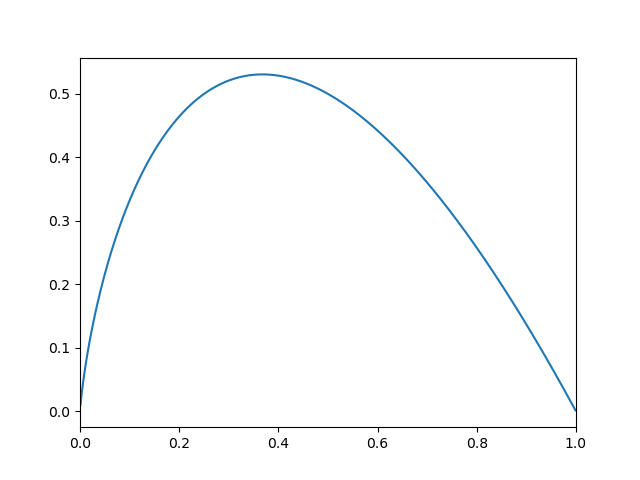

(0, 1)

In [2]:
import math
import numpy as np
import matplotlib.pyplot as plt
%matplotlib notebook

x = np.arange(0.001,1,0.001)
y = np.multiply(-x,np.log2(x))

plt.plot(x,y)
plt.xlim(0,1)

In [3]:
from math import log

next_x = 0.001  # We start the search at x=6
gamma = 0.0001  # Step size multiplier
precision = 0.000001  # Desired precision of result
max_iters = 10000 # Maximum number of iterations

# Derivative function
def df(x):
    return -(log(x) + 1)/log(2)


for _ in range(max_iters):
    current_x = next_x
    next_x = current_x + gamma * df(current_x)

    step = next_x + current_x
    if abs(step) <= precision:
        break

print("Maximum at ", next_x)

# The output for the above will be something like
# "Minimum at 2.2499646074278457"

Maximum at  0.3637718326437725


In [4]:
from typing import List
import math

def entropy(class_probabilities: List[float]) -> float:
    """Given list of probs, compute the entropy"""
    return sum(
        -p * math.log(p,2) 
        for p in class_probabilities 
        if p > 0
    )

assert entropy([1.0]) == 0
assert entropy([0.5,0.5]) == 1
assert 0.81 < entropy([0.25,0.75]) < 0.82

The data we'll use to elaborate on the concept will be in the form of `(input, label)`.

In [5]:
from typing import Any
from collections import Counter

def class_probabilities(labels: List[Any]) -> List[float]:
    total_count = len(labels)
    return [
        count / total_count 
        for count in Counter(labels).values()
    ]

def data_entropy(labels: List[Any]) -> float:
    return entropy(class_probabilities(labels))

assert data_entropy(['a']) == 0
assert data_entropy([True,False]) == 1
assert data_entropy([3,4,4,4]) == entropy([0.25,0.75])

## Entropy of a partition

Each stage of a decision tree asks a question whose answer partitions data into one or (hopefully) more subsets.

"Is it a team sport?" partitions the data into team sports and non-team sports.

We can use entropy as a way of figuring out whether our question was a good one or a bad one: we want our questions to result in partitioning of the data into subsets that have low entropy (are highly certain).

For example, "Does it require weigh-ins?" probably isn't a great question because it splits the dataset (all sports) into:
- boxing and MMA; and
- every other sport. 

The first subset has low uncertainty, but the second has high uncertainty.

In mathematical terms, if we partition our data $S$ into subsets $S_1, S_2, ... ,S_m$ containing proportions $q_1, q_2, ..., q_m$ of the dataset, the entropy of the partition is a weighted sum of the entropy of the m subsets

$$H = q_1H(S_1) + ... + q_mH(S_m)$$

which in code looks like:

In [6]:
def partition_entropy(subsets: List[List[Any]]) -> float:
    """Returns the entropy from this partition of data into subsets"""
    total_count = sum(len(subset) for subset in subsets)
    return sum(data_entropy(subset) * len(subset) / total_count 
               for subset in subsets)

# Creating a decision tree

In [17]:
from typing import NamedTuple, Optional

class Candidate(NamedTuple):
    level: str
    lang: str
    tweets: bool
    phd: bool
    did_well: Optional[bool] = None # allow unlabelled
        
inputs = [
    Candidate('Senior', 'Java',   False, False, False),
    Candidate('Senior', 'Java',   False, True,  False),
    Candidate('Mid',    'Python', False, False, True),
    Candidate('Junior', 'Python', False, False, True),
    Candidate('Junior', 'R',      True,  False, True),
    Candidate('Junior', 'R',      True,  True,  False),
    Candidate('Mid',    'R',      True,  True,  True),
    Candidate('Senior', 'Python', False, False, False),
    Candidate('Senior', 'R',      True,  False, True),
    Candidate('Junior', 'Python', True,  False, True),
    Candidate('Senior', 'Python', True,  True,  True),
    Candidate('Mid',    'Python', False, True,  True),
    Candidate('Mid',    'Java',   True,  False, True),
    Candidate('Junior', 'Python', False, True,  False)
         ]

Trees are comprised of:

- `decision nodes` that ask a question and direct you differently depending on the answer (like gatekeepers); and
- `leaf nodes` that give you predictions.

Say you're given labelled data that has various attributes that you can consider branching on.

The "ID3" algorithm proceeds as follows:

- If the data all have the same label, create a leaf node that predicts the label then stop.

- If the list of attributes is empty, meaning there are no more questions to ask, create a leaf node that predicts the most common label and then stop.

- Otherwise, try partitioning the data by each of the attributes.

- Choose the partition with the lowest partition entropy.

- Add a decision node based on the chosen attribute.

- Recur on each partitioned subset using the remaining attributes.

This algorithm is short-term in its thinking: it always the best option for it *right now*, which isn't always going to be the best option overall. There could be better decision paths that start off with a worse first choice that ID3 will always be blind to by defintion. 

But, it's a good place to start.

This function returns partitioned data:

In [18]:
from typing import Dict, TypeVar
from collections import defaultdict

T = TypeVar('T')

def partition_by(inputs: List[T],
                 attribute: str) -> Dict[Any,List[T]]:
    """Partition the inputs inot lists based on the specified attribute."""
    partitions: Dict[Any,List[T]] = defaultdict(list)
        
    for input_ in inputs:
        key = getattr(input_,attribute)
        partitions[key].append(input_)
        
    return partitions

partition_by(inputs=inputs,attribute='level')

defaultdict(list,
            {'Senior': [Candidate(level='Senior', lang='Java', tweets=False, phd=False, did_well=False),
              Candidate(level='Senior', lang='Java', tweets=False, phd=True, did_well=False),
              Candidate(level='Senior', lang='Python', tweets=False, phd=False, did_well=False),
              Candidate(level='Senior', lang='R', tweets=True, phd=False, did_well=True),
              Candidate(level='Senior', lang='Python', tweets=True, phd=True, did_well=True)],
             'Mid': [Candidate(level='Mid', lang='Python', tweets=False, phd=False, did_well=True),
              Candidate(level='Mid', lang='R', tweets=True, phd=True, did_well=True),
              Candidate(level='Mid', lang='Python', tweets=False, phd=True, did_well=True),
              Candidate(level='Mid', lang='Java', tweets=True, phd=False, did_well=True)],
             'Junior': [Candidate(level='Junior', lang='Python', tweets=False, phd=False, did_well=True),
              Candidate(le

And this function computes the entropy:

In [9]:
def partition_entropy_by(inputs: List[Any],
                         attribute: str,
                         label_attribute: str) -> float:
    """Compute the entropy of a given partition"""
    partitions = partition_by(inputs,attribute)
    
    labels = [
        [getattr(input_,label_attribute) for input_ in partition]
        for partition in partitions.values()
    ]
    
    return partition_entropy(labels)

Then take the partition with the minimum entropy:

In [10]:
for key in "level,lang,tweets,phd".split(","):
    print(key,partition_entropy_by(inputs,key,'did_well'))
    
assert 0.69 < partition_entropy_by(inputs, 'level', 'did_well')  < 0.70
assert 0.86 < partition_entropy_by(inputs, 'lang', 'did_well')   < 0.87
assert 0.78 < partition_entropy_by(inputs, 'tweets', 'did_well') < 0.79
assert 0.89 < partition_entropy_by(inputs, 'phd', 'did_well')    < 0.90

level 0.6935361388961919
lang 0.8601317128547441
tweets 0.7884504573082896
phd 0.8921589282623617


The minimum entropy is on the split by `level`, so the next step is to do a subtree based on each possible `level` value.

Every Mid level candidate is labelled `True` which means that the Mid subtree is a leaf node predicting `True`.

For `Senior` candidates there are a mix of `True` and `False` labels, so we need to split again:

In [11]:
senior_inputs = [foo for foo in inputs if foo.level == "Senior"]

for key in "lang,tweets,phd".split(","):
    print(key,partition_entropy_by(senior_inputs,key,'did_well'))

assert 0.4 == partition_entropy_by(senior_inputs, 'lang', 'did_well')
assert 0.0 == partition_entropy_by(senior_inputs, 'tweets', 'did_well')
assert 0.95 < partition_entropy_by(senior_inputs, 'phd', 'did_well') < 0.96

lang 0.4
tweets 0.0
phd 0.9509775004326938


The next split should be on `tweets` (a zero-entropy partition). For these `Senior` level candidates "yes" tweets always result in `True` while "no" tweets always result in `False`.

Taking a different path, for `Junior` candidates:

In [12]:
junior_inputs = [foo for foo in inputs if foo.level == "Junior"]

for key in "lang,tweets,phd".split(","):
    print(key,partition_entropy_by(junior_inputs,key,'did_well'))

lang 0.9509775004326938
tweets 0.9509775004326938
phd 0.0


Splitting on `phd`, no PhD always results in `True` and PhD always results in `False`.

We have our complete decision tree!

![Full decision tree](dsf2_1703.png)

# Generalising the decision tree structure

Decision trees have two core components: `decision nodes` (splits) and `leaf nodes`.

`Decision nodes` or splits pick an attribute to split on, subtrees for specific values of that attribute and maybe a default value to use when we see unknown/null/na values.

In [13]:
from typing import NamedTuple, Union, Any

class Leaf(NamedTuple):
    value: Any

class Split(NamedTuple):
    attribute: str
    subtrees: dict
    default_value: Any = None
        

DecisionTree = Union[Leaf,Split]

Converting the last tree into this format:

In [14]:
hiring_tree = Split('level',{ # First look at level
    'Junior': Split('phd', {  # if level is Junior then look at phd
        False: Leaf(True),     # if phd is False predict True
        True: Leaf(False)     # If phd is True predict False
    }),
    'Mid': Leaf(True),        # If level is mid, predict True
    'Senior': Split('tweets',{# If level is Senior, look at tweets
        False: Leaf(False),    # if tweets is False, predict False 
        True: Leaf(True)      # if tweets is True, predict True
    })
})

In [15]:
def classify(tree: DecisionTree, 
             input: Any) -> Any:
    """classify the input using the given decision tree"""

    # If this is a leaf node, return its value
    if isinstance(tree, Leaf):
        return tree.value

    # Otherwise this tree consists of an attribute to split on
    # and a dictionary whose keys are values of that attribute
    # and whose values are subtrees to consider next
    subtree_key = getattr(input, tree.attribute)

    if subtree_key not in tree.subtrees:   # If no subtree for key,
        return tree.default_value          # return the default value.

    subtree = tree.subtrees[subtree_key]   # Choose the appropriate subtree
    return classify(subtree, input)        # and use it to classify the input.

In [16]:
def build_tree_id3(inputs: List[Any],
                   split_attributes: List[str],
                   target_attribute: str) -> DecisionTree:
    # Count target labels
    label_counts = Counter(getattr(input, target_attribute)
                           for input in inputs)
    most_common_label = label_counts.most_common(1)[0][0]

    # If there's a unique label, predict it
    if len(label_counts) == 1:
        return Leaf(most_common_label)

    # If no split attributes left, return the majority label
    if not split_attributes:
        return Leaf(most_common_label)

    # Otherwise split by the best attribute

    def split_entropy(attribute: str) -> float:
        """Helper function for finding the best attribute"""
        return partition_entropy_by(inputs, 
                                    attribute, 
                                    target_attribute)

    best_attribute = min(split_attributes, key=split_entropy)

    partitions = partition_by(inputs, best_attribute)
    new_attributes = [a for a in split_attributes if a != best_attribute]

    # Recursively build the subtrees
    subtrees = {attribute_value : build_tree_id3(subset,
                                                 new_attributes,
                                                 target_attribute)
                for attribute_value, subset in partitions.items()}

    return Split(best_attribute, 
                 subtrees, 
                 default_value=most_common_label)